# Taller 3 - Deep Learning

**Curso: Machine Learning y Deep Learning**

**Diplomado en Data Science**

Nombre: Dr. Ing. Rodrigo Salas (rodrigo.salas@uv.cl)


- Nombre integrante 1:Juan Pablo González Collao
- Nombre integrante 2:Pablo Omar Walters Barraza
- Nombre integrante 3:___________________________

Fecha de entrega: Lunes 25 de Julio 2022

A continuación coloque todos los toolbox que utilizó para el desarrollo de esta actividad.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from collections import defaultdict
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import statsmodels as sm
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.compat import lzip

import tensorflow as tf
import keras as k
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers
from keras.layers import Dropout
from keras.layers import LSTM


import os

import random

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split



#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
def performance_results(y_real, y_predict, text):

    val={'Mean Absolute Error': mean_absolute_error(y_real, y_predict), 'Root Mean Squared Error': mean_squared_error(y_real, y_predict, squared=False),'MAPE': mean_absolute_percentage_error(y_real, y_predict), 'R2 score': r2_score(y_real, y_predict),'Spearman r':spearmanr(y_real, y_predict)[0],'Pearson r':pearsonr(y_real, y_predict)[0]}
    ds=pd.DataFrame(val,index=[text])
    #print('Mean Absolute Error', mean_absolute_error(y_real, y_predict) )
    #print('Root Mean Squared Error', mean_squared_error(y_real, y_predict, squared=False) )
    #print('MAPE', mean_absolute_percentage_error(y_real, y_predict))
    #print('R2 score:',r2_score(y_real, y_predict))
    #print('Spearman r:', spearmanr(y_real, y_predict)[0])
    #print('Pearson r:', pearsonr(y_real, y_predict)[0])
    
    return ds
    
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Deep Learning aplicado a la predicción en Series DataFrameiempo (30 puntos)

En esta pregunta se realizará un estudio para predecir el nivel de contaminación diario en la Región Metropoltana de Santiago. Para ello se utilizarán los registros de PM10 que provee el Sistema de Información Nacional de la Calidad del Aire SINCA

- [SINCA](https://sinca.mma.gob.cl/)
- [Datos](https://sinca.mma.gob.cl/index.php/region/index/id/M)

La Región Metropolitana posee varias estaciones de monitoreo. Para ello su grupo deberá seleccionar una de las estaciones y descargar los registros diarios a partir del 1ero de enero del 2018 (buscar alguna estación que tenga estos registros)


**1.1.** Realizar la lectura del archivo y guardar la información en un DataFrame de pandas. Convertir la variable de las fechas a un tipo de dato Tiempo. Graficar la Serie de Tiempo.

In [3]:
df = pd.read_csv('C:\\Users\\pablo.walters\\Desktop\\clase\\taller 3\\datos_180101_220713.csv',sep=";").fillna(method="bfill")
df.dtypes

FECHA (YYMMDD)              int64
HORA (HHMM)                 int64
Registros validados       float64
Registros preliminares    float64
Registros no validados    float64
Unnamed: 5                float64
dtype: object

In [4]:
df['Registros validados'][1642:1654]=df['Registros preliminares'].tail(12)
df['n_fecha']=pd.date_range('2018-01-01', periods=1654, freq='D')
df=df.drop(['FECHA (YYMMDD)', 'HORA (HHMM)','Registros preliminares', 'Registros no validados', 'Unnamed: 5'], axis=1)

C:\Users\pablo.walters\AppData\Local\Temp\ipykernel_15036\3200011525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Registros validados'][1642:1654]=df['Registros preliminares'].tail(12)


In [5]:
print(df.dtypes)
df=df.set_index('n_fecha')
df

Registros validados           float64
n_fecha                datetime64[ns]
dtype: object


,Registros validados
n_fecha,
2018-01-01,41.0
2018-01-02,39.0
2018-01-03,47.0
2018-01-04,37.0
2018-01-05,30.0
...,...
2022-07-08,86.0
2022-07-09,29.0
2022-07-10,13.0


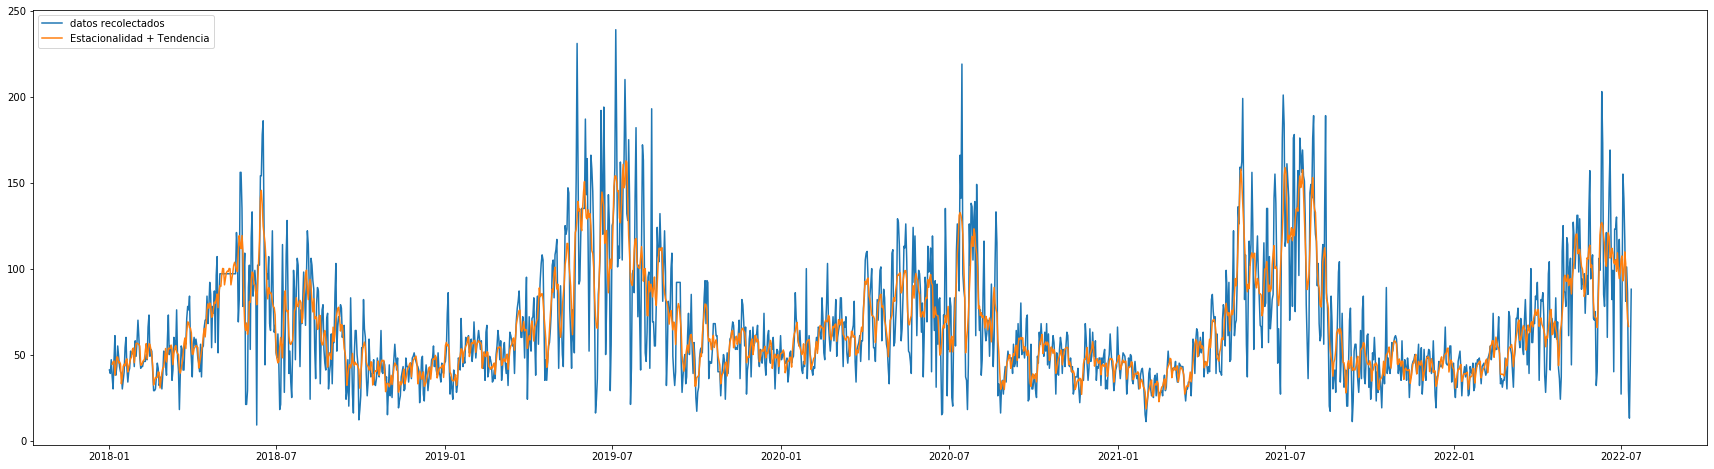

In [6]:
plt.figure(figsize = (30,8))
result=seasonal_decompose(df, model='additive', period=7)
trend_estimate = result.trend
seasonal_estimate = result.seasonal
residual_estimate = result.resid


plt.plot(df, label='datos recolectados') 
plt.plot(trend_estimate+seasonal_estimate, label='Estacionalidad + Tendencia') 
plt.legend(loc='upper left');

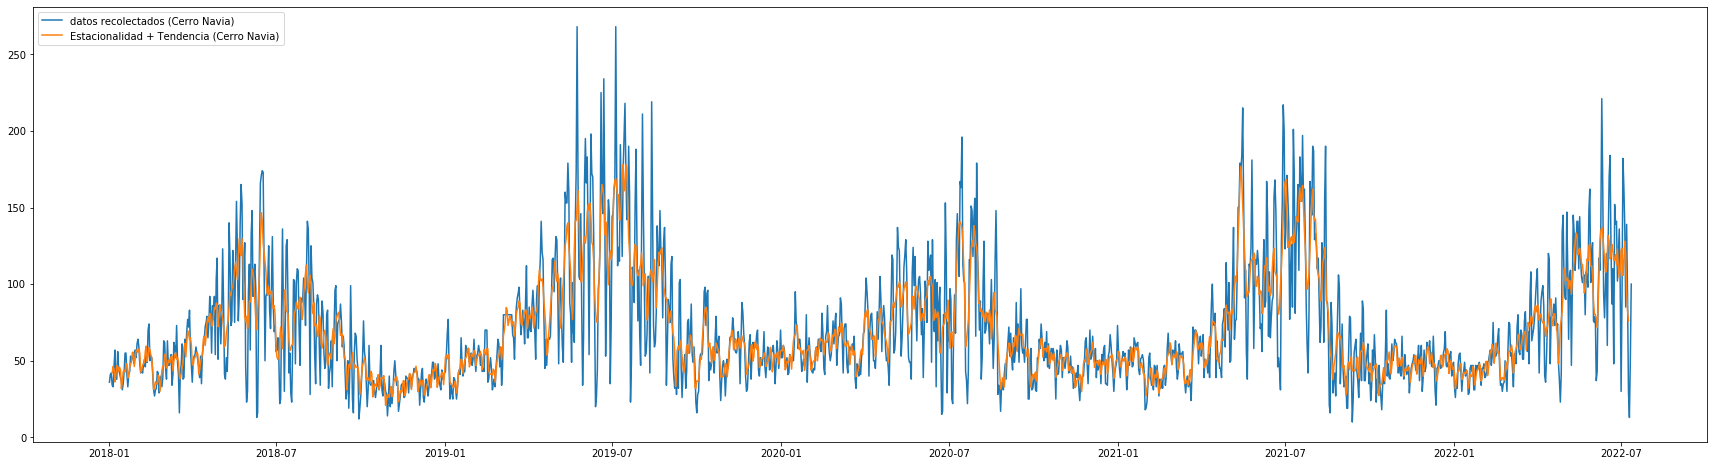

In [7]:
from IPython.display import Image
Image(filename='CERRONAVIA.PNG', width = 3000, height = 800)

A modo de comparación, se grafica e importa imagen de la serie de tiempo de otra estación de monitoreo (Cerro Navia).
A simple vista se puede observar, una muy similar tendencia y estacionalidad, con un nivel de ruido de magnitudes similares.

In [8]:
#Datos sin residuos

dfs=trend_estimate+seasonal_estimate
dfs=dfs.dropna()
dfs

n_fecha
2018-01-04     44.388088
2018-01-05     45.808185
2018-01-06     46.227071
2018-01-07     37.980638
2018-01-08     43.217720
                 ...    
2022-07-05    109.728359
2022-07-06    102.935654
2022-07-07     82.388088
2022-07-08     70.665327
2022-07-09     66.369928
Length: 1648, dtype: float64

**1.2.** Explicar brevemente cuál es el objetivo de este conjunto de datos. Indicar cuánto es la cantidad de datos. Explicar brevemente el significado de la variable.

Respuesta:

El dataset consiste en las concentraciones ambientales promedio diario de material particulado MP10, basado en el monitoreo continuo de este contaminante, en la estación de Monitoreo de Pudahuel, para el periodo 1 de enero de 2018 al 13 de julio del 2022, disponible en el Sistema de Información Nacional de la Calidad del Aire SINCA.

El objetivo del conjunto de datos es realizar una predicción de los niveles de contaminación por MP10 en la región metropolitana, utilizando herramientas de machine learning.

El conjunto de datos cuenta con 5 variables, 2 variables de enteros que muestran la fecha y hora y 3 variable de registros con distinto niveles de validación (Registro validado, preliminar y no validado).

Se tienen 1654 observaciones, donde 1630 cuentan con registros, al menos validados o preliminares, y de las 24 obseraciones restantes, 6 son registros no validados y 18 faltantes.

**1.3.** Construir la matriz de entrada $X$ considerando un lag de 7 (rezagos de una semana). Separar el conjunto de datos en una matriz $X$ con las variables de entrada y en el target $y$. 

In [9]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        #print(a)
        #print(dataset[i + look_back, 0])
        #print("______________")
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

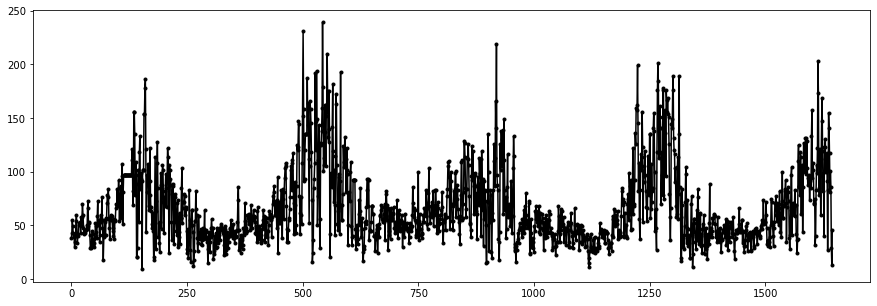

In [10]:
lags = 7
ts= df['Registros validados'].values
ts1= dfs.values




X, y = create_dataset(ts.reshape(-1,1), look_back=lags)
X1, y1 = create_dataset(ts1.reshape(-1,1), look_back=lags)




plt.figure(figsize=(15,5))
plt.plot(y,'.-k')

**1.4.** Separar el conjunto de datos en conjunto de entrenamiento y en conjunto de test. Considerar el período comprendido entre el 2018-2021 para los datos para entrenamiento, y el año 2022 para test.

In [11]:
Train_X = X[0:1461]
Train_y = y[0:1461]
Test_X = X[1462:1654]
Test_y = y[1462:1654]

Train_X1 = X1[0:1461]
Train_y1 = y1[0:1461]
Test_X1 = X1[1462:1654]
Test_y1 = y1[1462:1654]


print('Train_X:',Train_X.shape)
print('Train_y:',Train_y.shape)
print('Test_X:',Test_X.shape)
print('Test_y:',Test_y.shape)

print('Train_X1:',Train_X1.shape)
print('Train_y1:',Train_y1.shape)
print('Test_X1:',Test_X1.shape)
print('Test_y1:',Test_y1.shape)

#Train: (1461, 1)
#Test: (193, 1)

Train_X: (1461, 7)
Train_y: (1461,)
Test_X: (184, 7)
Test_y: (184,)
Train_X1: (1461, 7)
Train_y1: (1461,)
Test_X1: (178, 7)
Test_y1: (178,)


In [12]:
Train_y

array([38., 43., 55., ..., 46., 49., 52.])

**1.5.** Estandarizar los datos de entrada del conjunto de entrenamiento y test utilizando el "standard scaler". (El standar scaler se ajusta al conjunto de entranamiento y luego se transforman los datos del conjunto de entrenamiento y el de test)

In [13]:
ss = StandardScaler().fit(Train_X)
train_data = ss.transform(Train_X)
test_data = ss.transform(Test_X)

ss1 = StandardScaler().fit(Train_X1)
train_data1 = ss.transform(Train_X1)
test_data1 = ss.transform(Test_X1)
train_data

array([[-0.68921935, -0.7465431 , -0.51559497, ..., -1.00477007,
        -0.51557162, -0.11228185],
       [-0.74686308, -0.51600608, -0.80369083, ..., -0.51513022,
        -0.11224025, -0.77491038],
       [-0.51628817, -0.80417736, -1.00535793, ..., -0.1118974 ,
        -0.77485607, -0.6308607 ],
       ...,
       [-0.8909724 , -0.60245746, -0.57321414, ..., -1.1487818 ,
        -0.83247483, -0.97657994],
       [-0.60275376, -0.57364034, -0.97654835, ..., -0.83195601,
        -0.97652175, -0.54443089],
       [-0.5739319 , -0.97708013, -1.14940586, ..., -0.97596773,
        -0.544381  , -0.45800108]])

NOTA:
Es importante destacar que para evitar fugas en el modelo, se realizó la estandarización de los datos de entrada, ajustando el escalamiento previamente al conjunto de entrenamiento.

**1.6.** Ajustar un modelo de MLP, definir un número adecuado de neuronas escondidas.


In [14]:
def create_MLP_model(neurons = 7):
    model = Sequential()
    model.add(Dense(int(neurons*2), input_dim=neurons, activation='sigmoid'))  
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

mlp_model = create_MLP_model(7)
mlp_model1 = create_MLP_model(7)
print(mlp_model.summary())
print(mlp_model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                112       
_________________________________________________________________
dropout (Dropout)            (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 14)                112       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14)                0         
_______________________________

In [15]:
mlp_model.fit(train_data, Train_y, epochs=100, batch_size=10,  shuffle=True, verbose=1)

Epoch 1/100
147/147 [==============================] - 0s 504us/step - loss: 5267.9688
Epoch 2/100
147/147 [==============================] - 0s 463us/step - loss: 5086.0317
Epoch 3/100
147/147 [==============================] - 0s 460us/step - loss: 4896.7295
Epoch 4/100
147/147 [==============================] - 0s 468us/step - loss: 4706.0015
Epoch 5/100
147/147 [==============================] - 0s 455us/step - loss: 4493.0864
Epoch 6/100
147/147 [==============================] - 0s 462us/step - loss: 4272.8081
Epoch 7/100
147/147 [==============================] - 0s 457us/step - loss: 4043.9368
Epoch 8/100
147/147 [==============================] - 0s 495us/step - loss: 3826.8047
Epoch 9/100
147/147 [==============================] - 0s 502us/step - loss: 3602.5867
Epoch 10/100
147/147 [==============================] - 0s 543us/step - loss: 3398.3833
Epoch 11/100
147/147 [==============================] - 0s 563us/step - loss: 3188.2034
Epoch 12/100
147/147 [===================

In [16]:
y_predict = mlp_model.predict(test_data)

mlp_r=performance_results(Test_y,y_predict.reshape(-1),"MPL con ruido")
mlp_r

,Mean Absolute Error,Root Mean Squared Error,MAPE,R2 score,Spearman r,Pearson r
MPL con ruido,16.687112,24.034368,27.319943,0.503052,0.754615,0.7166


In [17]:
mlp_model1.fit(train_data1, Train_y1, epochs=100, batch_size=10,  shuffle=True, verbose=1)

Epoch 1/100
147/147 [==============================] - 0s 489us/step - loss: 4914.5439
Epoch 2/100
147/147 [==============================] - 0s 475us/step - loss: 4722.6782
Epoch 3/100
147/147 [==============================] - 0s 475us/step - loss: 4524.3936
Epoch 4/100
147/147 [==============================] - 0s 466us/step - loss: 4332.8135
Epoch 5/100
147/147 [==============================] - 0s 474us/step - loss: 4140.7007
Epoch 6/100
147/147 [==============================] - 0s 492us/step - loss: 3931.9551
Epoch 7/100
147/147 [==============================] - 0s 485us/step - loss: 3732.6777
Epoch 8/100
147/147 [==============================] - 0s 488us/step - loss: 3528.6560
Epoch 9/100
147/147 [==============================] - 0s 488us/step - loss: 3299.6707
Epoch 10/100
147/147 [==============================] - 0s 485us/step - loss: 3078.3320
Epoch 11/100
147/147 [==============================] - 0s 516us/step - loss: 2870.4893
Epoch 12/100
147/147 [===================

In [18]:
y_predict1 = mlp_model1.predict(test_data1)
mlp_sr=performance_results(Test_y1,y_predict1.reshape(-1),"MLP sin ruido")
mlp_sr

,Mean Absolute Error,Root Mean Squared Error,MAPE,R2 score,Spearman r,Pearson r
MLP sin ruido,5.671728,7.303217,8.012593,0.920306,0.965481,0.965316


**1.7.** Ajustar un modelo de LSTM, definir un número adecuado de bloques.

In [19]:
def create_LSTM_model(neurons = 7, look_back = 1):
    model = Sequential()
    model.add(LSTM(int(neurons)*10, input_shape = (1, look_back)))
    model.add(Dropout(0.25))
    model.add(Dense(1,activation='linear'))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model


In [20]:
trainX = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
testX = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

trainX1 = np.reshape(train_data1, (train_data1.shape[0], 1, train_data1.shape[1]))
testX1 = np.reshape(test_data1, (test_data1.shape[0], 1, test_data1.shape[1]))


In [21]:
lstm_model = create_LSTM_model(20,lags)
print(lstm_model.summary())
lstm_model.fit(trainX, Train_y, epochs = 100, batch_size = 4, shuffle=False, verbose = 1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               166400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 166,601
Trainable params: 166,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
366/366 [==============================] - 1s 2ms/step - loss: 4929.0483
Epoch 2/100
366/366 [==============================] - 1s 2ms/step - loss: 2743.0010
Epoch 3/100
366/366 [==============================] - 1s 2ms/step - loss: 1406.2841
Epoch 4/100
366/366 [==============================] - 1s 2ms/step - loss: 802.2679
Epoch 5/100
366/366 [=============

In [22]:
y_predict2 = lstm_model.predict(testX)
lstm_r=performance_results(Test_y,y_predict2.reshape(-1),"LSTM con ruido")
lstm_r


,Mean Absolute Error,Root Mean Squared Error,MAPE,R2 score,Spearman r,Pearson r
LSTM con ruido,16.028496,22.309703,27.219646,0.571813,0.756128,0.75897


In [23]:
lstm_model1 = create_LSTM_model(20,lags)
print(lstm_model1.summary())
lstm_model1.fit(trainX1, Train_y1, epochs = 100, batch_size = 4, shuffle=False, verbose = 1)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               166400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 166,601
Trainable params: 166,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
366/366 [==============================] - 1s 2ms/step - loss: 4460.1201
Epoch 2/100
366/366 [==============================] - 1s 2ms/step - loss: 2297.5081
Epoch 3/100
366/366 [==============================] - 1s 2ms/step - loss: 944.9974
Epoch 4/100
366/366 [==============================] - 1s 2ms/step - loss: 320.4531
Epoch 5/100
366/366 [==============

In [24]:
y_predict4 = lstm_model1.predict(testX1)
lstm_sr=performance_results(Test_y1,y_predict4.reshape(-1),"LSTM sin ruido")
lstm_sr

,Mean Absolute Error,Root Mean Squared Error,MAPE,R2 score,Spearman r,Pearson r
LSTM sin ruido,4.581897,5.949508,6.703573,0.947111,0.969842,0.97419


**1.8.** Obtener las siguientes métricas de desempeño para el conjunto de Test:

- Mean Absolute Error
- Root Mean Squared Error
- MAPE
- R2 score
- Spearman r
- Person r

Realizar una tabla comparativa y concluir.

In [25]:
pd.concat([mlp_r,mlp_sr,lstm_r,lstm_sr])

,Mean Absolute Error,Root Mean Squared Error,MAPE,R2 score,Spearman r,Pearson r
MPL con ruido,16.687112,24.034368,27.319943,0.503052,0.754615,0.716600
MLP sin ruido,5.671728,7.303217,8.012593,0.920306,0.965481,0.965316
LSTM con ruido,16.028496,22.309703,27.219646,0.571813,0.756128,0.758970
LSTM sin ruido,4.581897,5.949508,6.703573,0.947111,0.969842,0.974190


**1.9.** Graficar las predicciones para el período 2022 en conjunto con los datos reales.

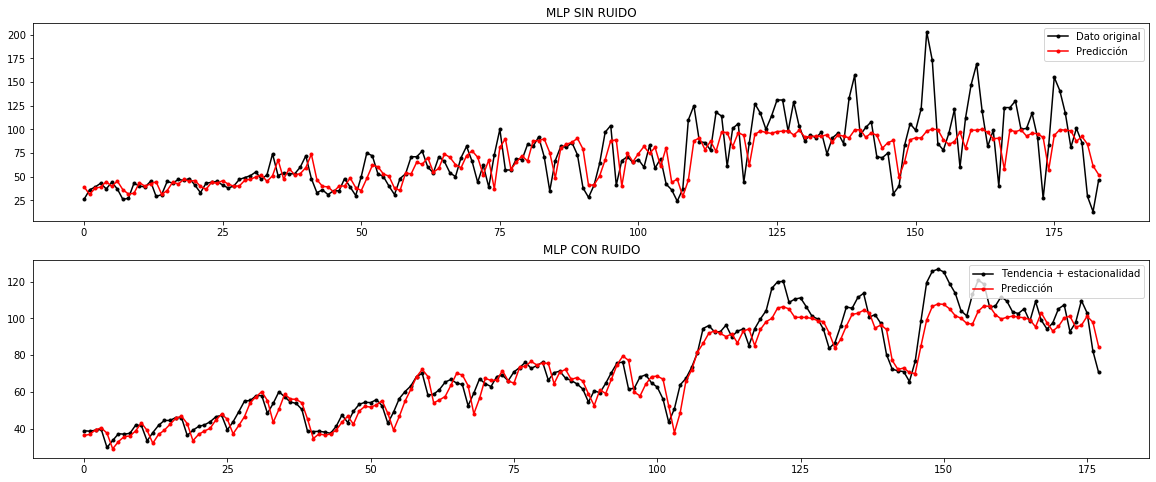

In [26]:
fig, axs = plt.subplots(2, 1,figsize=(20,8))

axs[0].plot(Test_y,'.-k', label='Dato original')
axs[0].plot(y_predict,'.-r', label='Predicción')
axs[0].title.set_text('MLP SIN RUIDO')

axs[1].title.set_text('MLP CON RUIDO')
axs[1].plot(Test_y1,'.-k', label='Tendencia + estacionalidad')
axs[1].plot(y_predict1,'.-r', label='Predicción')
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")


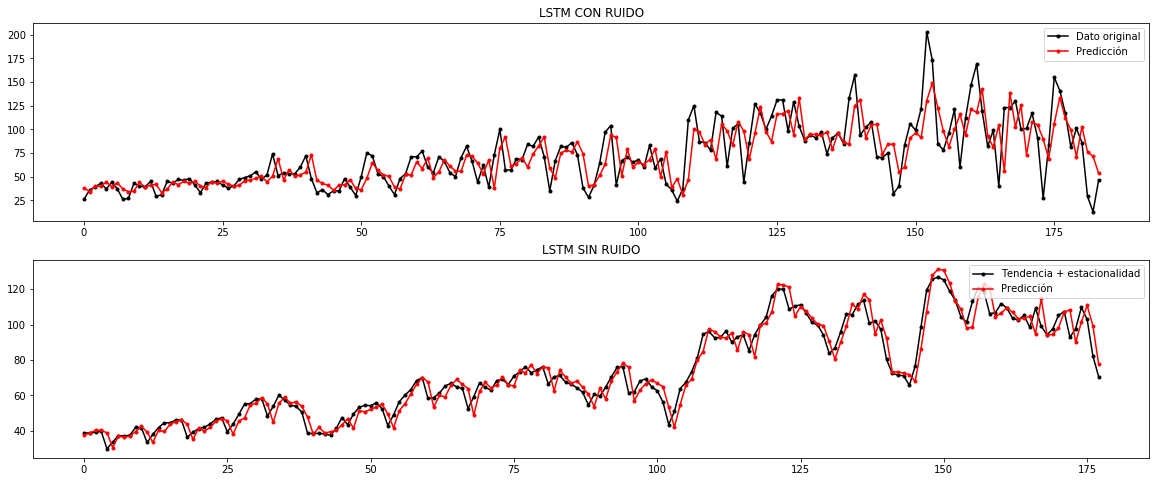

In [27]:
fig, axs = plt.subplots(2, 1,figsize=(20,8))

axs[0].plot(Test_y,'.-k', label='Dato original')
axs[0].plot(y_predict2,'.-r', label='Predicción')
axs[0].title.set_text('LSTM CON RUIDO')
axs[1].title.set_text('LSTM SIN RUIDO')
axs[1].plot(Test_y1,'.-k', label='Tendencia + estacionalidad')
axs[1].plot(y_predict4,'.-r', label='Predicción')
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")

**Concluir**

Para la creación de los modelos, se realizó pruebas con distintas configuraciones, las cuales no mostraban grandes diferencias al variar la cantidad de neuronas y capas. Se obtuvo el mejor desempeño con las siguientes configuraciones:

- MLP de 4 capas secuenciales, con 7 lags y 14 neuronas de entrada con activación sigmoidea, con un 25% de Dropout para reducir el ajuste y una capa de salida con 1 neurona con activación lineal. Lo que resulta en 127 parámetros a entrenar (112 en la capa densa y 15 a la salida).
- LSTM de 4 capas secuenciales, con 7 lags, 40 bloques, 14 neuronas de entrada con activación sigmoidea, con un 25% de Dropout para reducir el ajuste y una capa de salida con 1 neurona con activación lineal. Lo que resulta en 166601 parámetros a entrenar (166400 en la capa densa y 201 a la salida).

Teniendo en cuenta el alto nivel de ruido la serie de tiempo, se consideraron datos con y sin ruido, para evaluar los modelos, obteniendo desempeños considerablemente mejores para la serie de tiempo sin ruido, mejorando las métricas de correlación en más de un 20%, alcanzando valores sobre 0.96 en el Spearman y Pearson y sobre 0.92 para el R2 score.
Por otro lado, el MAPE mejoró en un 20%, llegando a valores menores de 8%, para ambos modelos.

Tanto las métricas de error como las de correlación, muestran un mejor desempeño para el modelo LSTM, lo que era esperado, ya que se trata de un modelo de mayor complejidad que tiene la capacidad de memorizar secuencias. Además, existe una gran diferencia en la cantidad de parámetros entrenados.
Sin embargo, la diferencia en el desempeño logrado por el LSTM se podría decir que es marginal, considerando las métricas MAPE, Spearman y Pearson, que lograron mejoras menores a un punto porcentual.

Se concluye que, para el set de datos seleccionado, se podría usar indistintamente los modelos MLP y LSTM, ya que presentan desempeños similares, sin embargo, dependiendo de la disponibilidad de recursos, podría ser recomendable utilizar el modelo más simple.


# 2. Clasificación de Imágenes usando redes neuronales convolucionales (30 puntos)

En esta pregunta se estudiará un modelo de red neuronal convolucional para la clasificación de imágenes. Para ello se utilizará el conjunto de datos de "piedra", "papel" y "tijeras" de Kaggle.

- [Rock, paper, scissors](https://www.kaggle.com/c/rock-paper-scissors)

Para la implementación de esta pregunta se pueden apoyar de los siguientes recursos:

[Ejemplo de CNN](https://www.kaggle.com/code/twhitehurst3/rock-paper-scissors-keras-cnn-99-accuracy/notebook)

[Ejemplo con Keras](https://valueml.com/rock-paper-scissor-prediction-using-keras-backend/)


In [28]:
def input_target_split(train_dir,labels):
    dataset = []
    count = 0
    for label in labels:
        folder = os.path.join(train_dir,label)
        for image in os.listdir(folder):
            img=load_img(os.path.join(folder,image), target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            
            dataset.append((img,count))
        print(f'\rCompleted: {label}',end='')
        count+=1
    random.shuffle(dataset)
    X, y = zip(*dataset)

    return np.array(X),np.array(y)

**2.1** Realizar la descarga del conjunto de datos



In [29]:
directory ='C:\\Users\\pablo.walters\\Desktop\\clase\\taller 3\\rockpaperscissors'
labels = ['paper','scissors','rock']
nb = len(labels)
X, y = input_target_split(directory,labels)

Completed: rocksors

**2.2** Mostrar 1 imagen de cada categoría: Piedra, Papel y Tijera.

In [50]:
np.unique(y,return_counts=True)

(array([0, 1, 2]), array([712, 750, 726], dtype=int64))

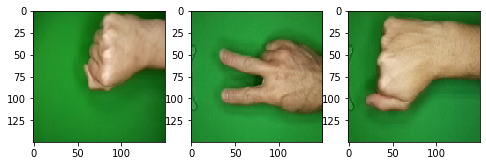

In [51]:
fig, axs = plt.subplots(1, 3,figsize=(8,8))

axs[0].imshow(X[0])
axs[1].imshow(X[1])
axs[2].imshow(X[2])


**2.3** Separar los datos en conjunto de entranamiento y Test. Considerar $70\%$ de los datos para entrenamiento.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**2.4.** Implementar una red neuronal convolucional

In [33]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=15,zoom_range=0.1,width_shift_range = 0.3,height_shift_range = 0.15,shear_range=0.1,fill_mode="nearest")
testgen = ImageDataGenerator()

datagen.fit(X_train)
testgen.fit(X_test)

XF=X_test
YF=y_test

y_train= np.eye(nb)[y_train]
y_test = np.eye(nb)[y_test]

In [34]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               2654336   
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

**2.5** Ajustar la red neuronal convolucional con el conjunto de entranamiento

In [35]:
filepath= "model_cnn_final.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)


callbacks_list = [
        checkpoint,
        early_stopping,]
hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=32),
                                        validation_data=testgen.flow(X_test,y_test,batch_size=32),
                                        epochs=50,
                                        callbacks=callbacks_list)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.1670 - accuracy: 0.3834
Epoch 00001: val_accuracy improved from -inf to 0.49924, saving model to model_cnn_final.h5
48/48 [==============================] - 14s 301ms/step - loss: 1.1670 - accuracy: 0.3834 - val_loss: 1.0541 - val_accuracy: 0.4992
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 1.0300 - accuracy: 0.4775
Epoch 00002: val_accuracy improved from 0.49924 to 0.69406, saving model to model_cnn_final.h5
48/48 [==============================] - 14s 283ms/step - loss: 1.0300 - accuracy: 0.4775 - val_loss: 0.9025 - val_accuracy: 0.6941
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.9067 - accuracy: 0.5807
Epoch 00003: val_accuracy improved from 0.69406 to 0.77778, saving model to model_cnn_final.h5
48/48 [==============================] - 15s 310ms/step - loss: 0.9067 - accuracy: 0.5807 - val_

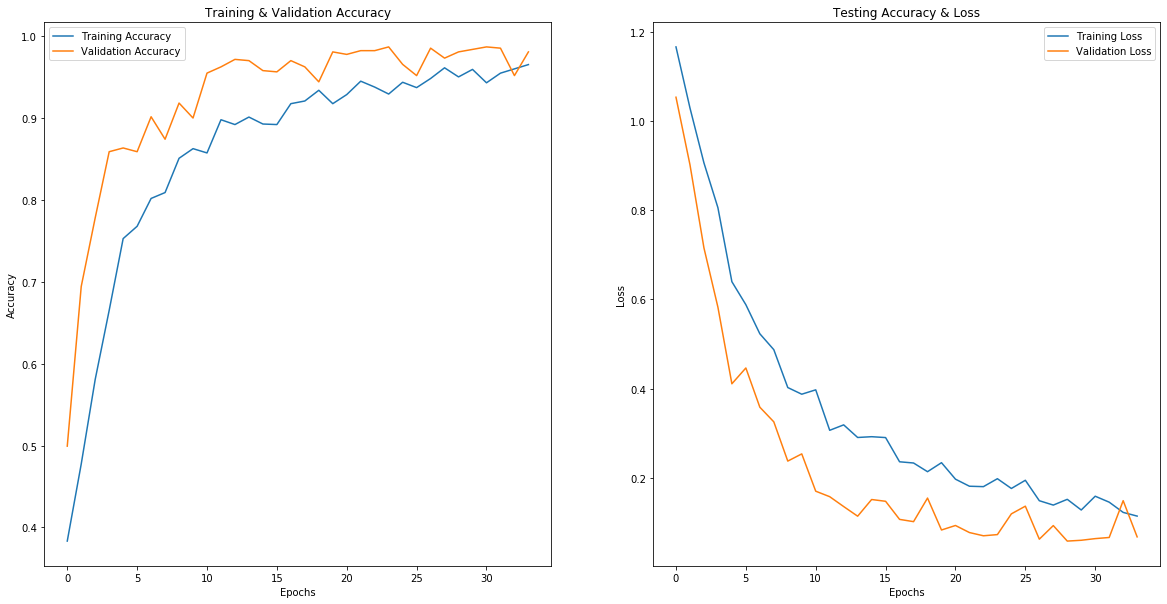

In [36]:
# Grafica de entrenamiento
epochs = [i for i in range(len(hist.epoch))]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs, hist.history['accuracy'],     label='Training Accuracy')
ax[0].plot(epochs, hist.history['val_accuracy'], label= 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, hist.history['loss'],     label = 'Training Loss')
ax[1].plot(epochs, hist.history['val_loss'], label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

**2.6** Obtener la matriz de confusión y el accuracy del clasificador para el conjunto de test.

In [37]:
model_saved = tf.keras.models.load_model('model_cnn_final.h5')
y_pred = model_saved.predict(X_test)
pred = np.argmax(y_pred,axis=1)
y_test_data = np.argmax(y_test,axis=1)

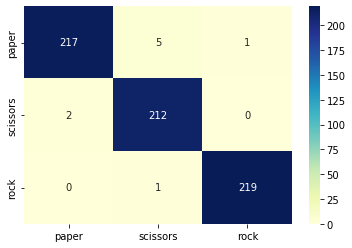

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm  = pd.DataFrame(confusion_matrix(y_test_data, pred),index=labels,columns=labels)
sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_test_data, pred,target_names = labels))

              precision    recall  f1-score   support

       paper       0.99      0.97      0.98       223
    scissors       0.97      0.99      0.98       214
        rock       1.00      1.00      1.00       220

    accuracy                           0.99       657
   macro avg       0.99      0.99      0.99       657
weighted avg       0.99      0.99      0.99       657



**2.7** Mostrar algunos ejemplos de predicción.

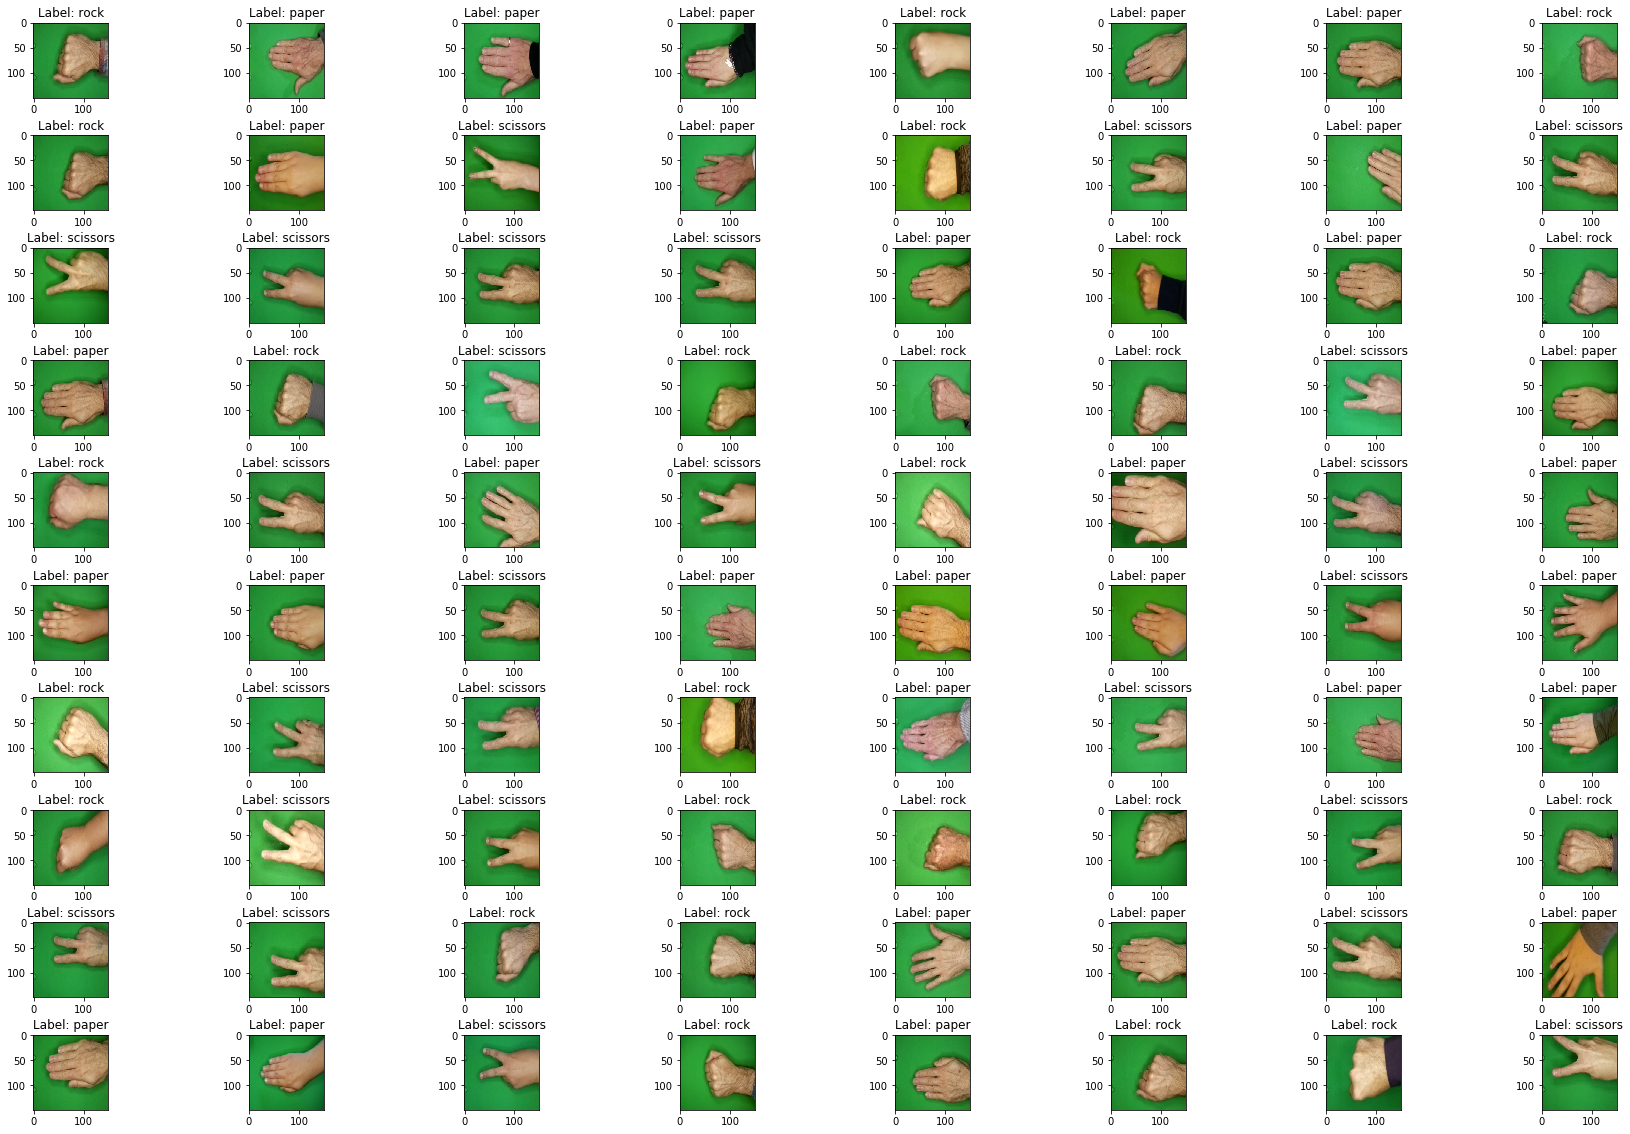

In [40]:

plt.figure(figsize = (30 , 20))
n = 0
for i in range(80):
    n+=1
    plt.subplot(10 , 8, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(XF[i])
    if pred[i] == YF [i]:
        plt.title(f'Label: {labels[pred[i]]}')
    else:
        plt.title('@@@ MALA:'+labels[pred[i]])

Conclusión de la actividad:

Para la clasificación de imágenes “rock paper scissors”, se crea una red neuronal convolucional con 2 niveles convolucionales que parten por una capa con 16 filtros de 3 por 3, con función de activación relu. Seguida por 1 capa de maxpooling y finalmente 2 capas densas con función de activación relu y softmax. Resultando en 2,657,491 parámetros a entrenar.

Se ajustó el modelo con el conjunto de entrenamiento (70%) con 50 épocas y 32 de batch, obteniendo una alta exactitud (0.9802).

Al observar las gráficas del historial de entrenamiento del modelo, se puede notar un rápido aumento de la exactitud, en las primeras 5 épocas, de igual forma se observa una rápida disminución del error, en el mismo periodo.
Por otro lado, los datos de validación obtuvieron un mejor desempeño a lo largo de casi todo el proceso.
Finalmente, al evaluar el mejor modelo de clasificación con el conjunto de test, se obtienen desempeños altísimos, cercanos al 100%.

Se concluye que los modelos de redes neuronales convolucionales, por su alta complejidad, tienen performances superiores a los modelos multicapa utilizados anteriormente.